Generate plots based on parametric dataset (compare 4 methods - two full signal and two trial-based):
* % of failed estimates (failed estimation and negative R-squared)
* ACF decline in specific range
* CI: 0 in the interval, width?
* R-squared (on unit level and as %)

Inclusion criteria:
* non zero bins
* 1 hz of activity
* R-squared > 0.5

In [1]:
import numpy as np
import pandas as pd
import pickle
import random

from isttc.scripts.cfg_global import project_folder_path

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import LinearSegmentedColormap

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
dataset_folder = project_folder_path + 'results\\synthetic\\dataset\\fig2_3_4a\\'
results_folder = project_folder_path + 'results\\synthetic\\results\\param_fr_alpha_tau\\'

fig_folder = project_folder_path + 'results\\synthetic\\fig_drafts_paper\\inclusion\\'

In [29]:
save_fig = True

### Load data

In [5]:
tau_plot_all_long_df = pd.read_pickle(results_folder + 'tau_plot_long_var_trials_with_nans_df.pkl')
tau_plot_all_long_df.rename(columns={'decline_150_250': 'acf_decline'}, inplace=True)

tau_plot_all_long_df['ci_zero_excluded'] = (
    (tau_plot_all_long_df['tau_lower'] > 0) | (tau_plot_all_long_df['tau_upper'] < 0)
).astype(int)

In [6]:
tau_plot_all_long_df

,unit_id,tau,tau_lower,tau_upper,fit_r_squared,acf_decline,method,tau_ms,fr,alpha,tau_ms_true,tau_diff_abs,tau_diff_rel,n_trials,log_tau_ms,ci_zero_excluded
0,0,5.054998,3.814326e+00,6.295671e+00,9.720046e-01,True,pearsonr_trial_avg,2.527499e+02,7.741821,0.851099,150.923515,1.018264e+02,6.746888e+01,40,2.402691,1
1,1,2.020436,1.463506e+00,2.577366e+00,9.449981e-01,True,pearsonr_trial_avg,1.010218e+02,4.394396,0.858098,147.947233,4.692543e+01,3.171768e+01,40,2.004415,1
2,2,79.998685,-6.688982e+02,8.288955e+02,7.739549e-01,False,pearsonr_trial_avg,3.999934e+03,8.587393,0.528805,267.002290,3.732932e+03,1.398090e+03,40,3.602053,0
3,3,10.973177,-2.232596e+01,4.427231e+01,4.124573e-01,True,pearsonr_trial_avg,5.486588e+02,6.976707,0.300692,194.403797,3.542550e+02,1.822264e+02,40,2.739302,0
4,4,1.883910,-6.130528e+00,9.898348e+00,6.726889e-02,False,pearsonr_trial_avg,9.419548e+01,0.950832,0.691458,239.986489,1.457910e+02,6.074967e+01,40,1.974030,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,99995,2.193187,-1.057410e+01,1.496047e+01,3.728416e-02,False,sttc_trial_concat,1.096594e+02,2.672839,0.244627,125.243251,1.558389e+01,1.244289e+01,100,2.040046,0
799996,99996,1.475838,6.146489e-01,2.337026e+00,7.978048e-01,True,sttc_trial_concat,7.379188e+01,5.754497,0.596987,94.481295,2.068941e+01,2.189789e+01,100,1.868009,1
799997,99997,2.201683,-3.782233e-01,4.781590e+00,4.887989e-01,False,sttc_trial_concat,1.100842e+02,5.604441,0.258915,174.189672,6.410551e+01,3.680213e+01,100,2.041725,0
799998,99998,66380.669763,-8.915330e+08,8.916658e+08,4.185009e-01,True,sttc_trial_concat,3.319033e+06,1.219057,0.187620,76.565797,3.318957e+06,4.334777e+06,100,6.521012,0


In [7]:
tau_plot_all_long_df.keys()

Index(['unit_id', 'tau', 'tau_lower', 'tau_upper', 'fit_r_squared',
       'acf_decline', 'method', 'tau_ms', 'fr', 'alpha', 'tau_ms_true',
       'tau_diff_abs', 'tau_diff_rel', 'n_trials', 'log_tau_ms',
       'ci_zero_excluded'],
      dtype='object')

### Plot overlall stats (without within unit comparison)

In [8]:
color_pearson_trail_avg = '#f4a91c' 
color_sttc_trail_concat = '#955da2' 

colors = [color_pearson_trail_avg, color_sttc_trail_concat]

#### % of failed estimates (failed estimation and negative R-squared)

In [10]:
def compute_exclusion(group):
    tau_nans = group['tau'].isna().sum()
    fit_r_squared_neg = (group['fit_r_squared'] < 0).sum()
    either_issue = ((group['tau'].isna()) | (group['fit_r_squared'] < 0)).sum()
    total = len(group)
    percent_tau_nans = 100 * tau_nans / total if total > 0 else 0
    percent_fit_r_squared_neg = 100 * fit_r_squared_neg / total if total > 0 else 0
    percent_either_issue = 100 * either_issue / total if total > 0 else 0
    return pd.Series({
        'tau_nans': tau_nans,
        'fit_r_squared_neg': fit_r_squared_neg,
        'exclusion': either_issue,
        'percent_tau_nans': percent_tau_nans,
        'percent_fit_r_squared_neg': percent_fit_r_squared_neg,
        'exclusion_perc': percent_either_issue
    })

exclusion_df = tau_plot_all_long_df.groupby(['method', 'n_trials']).apply(compute_exclusion).reset_index()
exclusion_df

C:\Users\ipochino\AppData\Local\Temp\ipykernel_7896\571421811.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  exclusion_df = tau_plot_all_long_df.groupby(['method', 'n_trials']).apply(compute_exclusion).reset_index()


,method,n_trials,tau_nans,fit_r_squared_neg,exclusion,percent_tau_nans,percent_fit_r_squared_neg,exclusion_perc
0,pearsonr_trial_avg,40,12393.0,4201.0,16594.0,12.393,4.201,16.594
1,pearsonr_trial_avg,60,8373.0,3284.0,11657.0,8.373,3.284,11.657
2,pearsonr_trial_avg,80,6228.0,2676.0,8904.0,6.228,2.676,8.904
3,pearsonr_trial_avg,100,4941.0,2253.0,7194.0,4.941,2.253,7.194
4,sttc_trial_concat,40,0.0,6268.0,6268.0,0.000,6.268,6.268
5,sttc_trial_concat,60,0.0,4645.0,4645.0,0.000,4.645,4.645
6,sttc_trial_concat,80,0.0,3721.0,3721.0,0.000,3.721,3.721
7,sttc_trial_concat,100,0.0,3149.0,3149.0,0.000,3.149,3.149


In [17]:
def plot_one_threshold_jittered_lines(ax, df, field_to_plot, jitter=0.15, seed=None, plot_lines=False):
    if seed is not None:
        np.random.seed(seed)

    methods = [
        ("pearsonr_trial_avg", color_pearson_trail_avg, "pearsonr_avg"),
        # ("sttc_trial_avg",     color_sttc_trail_avg,     "sttc_avg"),
        ("sttc_trial_concat",  color_sttc_trail_concat,  "sttc_concat"),
        # ("acf_full",           color_acf_full,           "acf_full"),
        # ("isttc_full",         color_isttc_full,         "isttc_full"),
    ]

    # fixed ordering of intervals
    cats = list(df["n_trials"].unique())
    idx_map = {cat:i for i,cat in enumerate(cats)}

    for method, col, label in methods:
        sub = df[df["method"] == method]
        # map string-labels to integer indices
        x0 = np.array([idx_map[s] for s in sub["n_trials"]])
        y  = sub[field_to_plot].values

        #  one jitter per point
        offsets = np.random.uniform(-jitter, jitter, size=len(x0))
        xj = x0 + offsets

        if plot_lines:
            order = np.argsort(x0)
            ax.plot(xj[order], y[order],
                    color=col,
                    linewidth=0.8,
                    alpha=1)
        # plot jittered points
        ax.scatter(xj, y,
                   color=col,
                   s=40,
                   marker="o",
                   label=label)

    ax.set_xticks(np.arange(len(cats)))
    ax.set_xticklabels(cats)

#### ACF decline and CI without zero

In [12]:
included_df = tau_plot_all_long_df.query('tau.notna() and fit_r_squared >= 0').copy()
print(f'len {len(included_df)}')
included_df.groupby(by='method', as_index=False).count()

len 737868


,method,unit_id,tau,tau_lower,tau_upper,fit_r_squared,acf_decline,tau_ms,fr,alpha,tau_ms_true,tau_diff_abs,tau_diff_rel,n_trials,log_tau_ms,ci_zero_excluded
0,pearsonr_trial_avg,355651,355651,355651,355651,355651,355651,355651,355651,355651,355651,355651,355651,355651,355651,355651
1,sttc_trial_concat,382217,382217,382217,382217,382217,382217,382217,382217,382217,382217,382217,382217,382217,382217,382217


In [13]:
acf_decline_df = included_df.groupby(by=['method','n_trials']).agg(
    num_true=('acf_decline', lambda x: x.sum())
).assign(
    total=100000,
    percent_true=lambda x: 100 * x['num_true'] / x['total']
).reset_index()
acf_decline_df

,method,n_trials,num_true,total,percent_true
0,pearsonr_trial_avg,40,53376,100000,53.376
1,pearsonr_trial_avg,60,60068,100000,60.068
2,pearsonr_trial_avg,80,64283,100000,64.283
3,pearsonr_trial_avg,100,66963,100000,66.963
4,sttc_trial_concat,40,61431,100000,61.431
5,sttc_trial_concat,60,65726,100000,65.726
6,sttc_trial_concat,80,68388,100000,68.388
7,sttc_trial_concat,100,70510,100000,70.510


In [14]:
ci_zero_df = included_df.groupby(by=['method','n_trials']).agg(
    num_true=('ci_zero_excluded', lambda x: x.sum())
).assign(
    total=100000,
    percent_true=lambda x: 100 * x['num_true'] / x['total']
).reset_index()
ci_zero_df

,method,n_trials,num_true,total,percent_true
0,pearsonr_trial_avg,40,30387,100000,30.387
1,pearsonr_trial_avg,60,39330,100000,39.330
2,pearsonr_trial_avg,80,45338,100000,45.338
3,pearsonr_trial_avg,100,49926,100000,49.926
4,sttc_trial_concat,40,38013,100000,38.013
5,sttc_trial_concat,60,45383,100000,45.383
6,sttc_trial_concat,80,50462,100000,50.462
7,sttc_trial_concat,100,54096,100000,54.096


#### R-squared > 0.5

In [15]:
fit_r2_df = included_df.groupby(by=['method','n_trials']).agg(
    num_true=('fit_r_squared', lambda x: (x >= 0.5).sum())
).assign(
    total=100000,
    percent_true=lambda x: 100 * x['num_true'] / x['total']
).reset_index()
fit_r2_df

,method,n_trials,num_true,total,percent_true
0,pearsonr_trial_avg,40,43915,100000,43.915
1,pearsonr_trial_avg,60,52719,100000,52.719
2,pearsonr_trial_avg,80,58261,100000,58.261
3,pearsonr_trial_avg,100,62577,100000,62.577
4,sttc_trial_concat,40,51630,100000,51.630
5,sttc_trial_concat,60,58544,100000,58.544
6,sttc_trial_concat,80,63019,100000,63.019
7,sttc_trial_concat,100,66318,100000,66.318


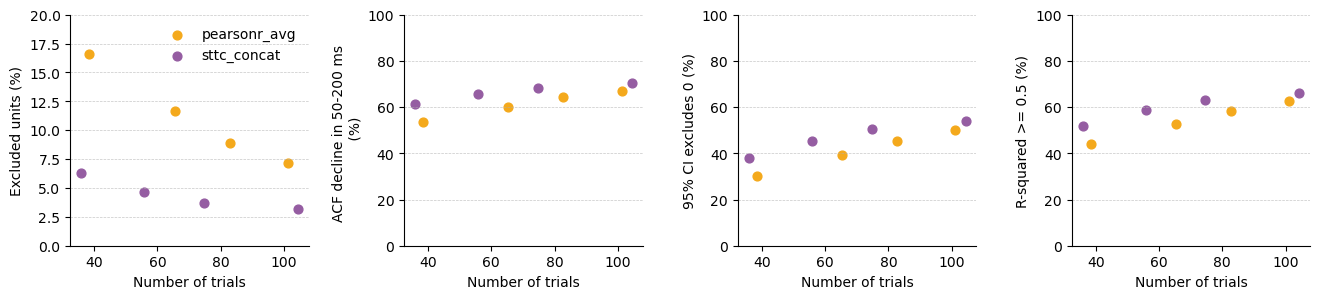

In [30]:
fig, axes = plt.subplots(1,4,figsize=(16,3))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

plot_one_threshold_jittered_lines(axes[0],
    exclusion_df, 'exclusion_perc',
    jitter=0.3, seed=42)

plot_one_threshold_jittered_lines(axes[1],
    acf_decline_df, 'percent_true',
    jitter=0.3, seed=42)

plot_one_threshold_jittered_lines(axes[2],
    ci_zero_df, 'percent_true',
    jitter=0.3, seed=42)

plot_one_threshold_jittered_lines(axes[3],
    fit_r2_df, 'percent_true',
    jitter=0.3, seed=42)

axes[0].set_ylabel('Excluded units (%)')
axes[1].set_ylabel('ACF decline in 50-200 ms \n (%)')
axes[2].set_ylabel('95% CI excludes 0 (%)')
axes[3].set_ylabel('R-squared >= 0.5 (%)')

axes[0].set_ylim([0, 20])
axes[1].set_ylim([0, 100])
axes[2].set_ylim([0, 100])
axes[3].set_ylim([0, 100])

for ax in axes.flat:
    ax.set_xlabel('Number of trials')
    ax.grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)
    sns.despine(ax=ax)
    
axes[0].legend(frameon=False)

if save_fig:
    plt.savefig(fig_folder + 'inclusion_trials.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'inclusion_trials.svg' , bbox_inches='tight')

C:\Users\ipochino\AppData\Local\Temp\ipykernel_7896\3377684851.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(frameon=False)
C:\Users\ipochino\AppData\Local\Temp\ipykernel_7896\3377684851.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(frameon=False)
C:\Users\ipochino\AppData\Local\Temp\ipykernel_7896\3377684851.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[2].legend(frameon=False)


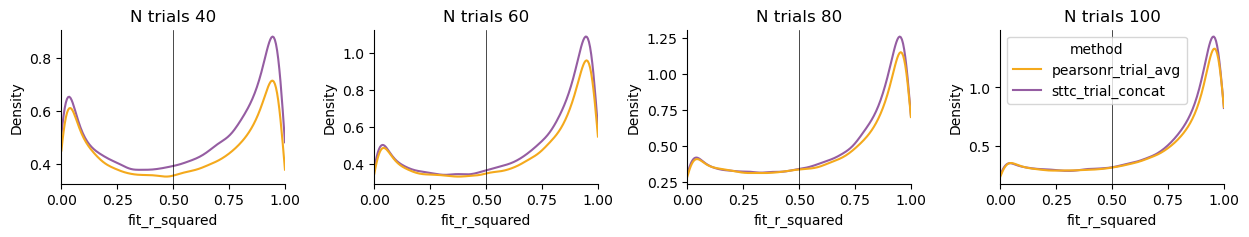

In [31]:
# R2 as KDE plots

fig, axes = plt.subplots(1,4, figsize=(15,2))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

durations_s_l = list(included_df["n_trials"].unique())

for duration_idx, duration in enumerate(durations_s_l):
    sns.kdeplot(
        data=included_df.query('n_trials == @duration'), 
        x='fit_r_squared', 
        hue='method', 
        hue_order=['pearsonr_trial_avg', 'sttc_trial_concat'],    
        clip=(0, 1),
        common_norm=True,  
        fill=False,
        palette=colors,
        legend=True,
        ax=axes[duration_idx]
    )
    axes[duration_idx].set_title(f'N trials {duration}')

for ax in axes.flat:
    ax.axvline(x=0.5, lw=0.5, c='k')
    ax.set_xlim([0,1])
    ax.set_xticks(np.linspace(0, 1, 5))

axes[0].legend(frameon=False)
axes[1].legend(frameon=False)
axes[2].legend(frameon=False)

sns.despine()

save_fig=True

if save_fig:
    plt.savefig(fig_folder + 'r2_kde_plot_trials.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'r2_kde_plot_trials.svg' , bbox_inches='tight')